# Laplacian regularization with kernels

In [1]:
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import eigh

from weights import NearestNeighbors, KernelComputer, KernelRegressor
np.random.seed(0)

The following command are using LaTeX backend to produce Type 1 font in PDF produced by matplotlib (it produces Type 3 otherwise). You can uncomment those lines.

In [2]:
%matplotlib inline
plt.rcParams['text.latex.preamble'] = [r'\usepackage{newtxmath}'] 
plt.rcParams['text.usetex'] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times"
plt.rc('text', usetex=True)

In [22]:
nb = 2000
nl = 4

def get_trainset(nb):
    theta = 2 * np.pi * np.random.rand(nb)
    cluster = np.random.choice(4, nb) + 1
    x = cluster * np.cos(theta)
    y = cluster * np.sin(theta)
    y1 = 2
    x1 = -2*np.sqrt(3)
    x2 = 1
    y2 = -2*np.sqrt(2)
    y3 = -1
    x3 = -np.sqrt(3)
    x4 = -1
    y4 = 0
    x_train = np.vstack((np.hstack((x1, x2, x3, x4, x)), np.hstack((y1, y2, y3, y4, y)))).T
    s_train = np.zeros(x_train.shape[0])
    s_train[0] = -1
    s_train[1] = +1
    s_train[2] = -1
    s_train[3] = +1
    return x_train, s_train

x_train, s_train = get_trainset(nb)

In [23]:
def get_x_test(num):
    x = np.linspace(-4.5, 4.5, num)
    X, Y = np.meshgrid(x, x)
    x_test = np.vstack((X.reshape(-1), Y.reshape(-1))).T
    return x_test, X, Y

In [24]:
num = 100
x_test, X, Y = get_x_test(num)

In [25]:
def get_K(x1, x2, sigma):
    # x1 = xtrain, x2 = xtest
    sigma2 = sigma ** 2
    K = x1 @ x2.T
    K *= 2
    _attr1 = np.sum(x1 ** 2, axis=1)[:, np.newaxis]
    K -= _attr1
    K -= np.sum(x2 ** 2, axis=1)
    K /= 2*sigma2
    np.exp(K, out=K)
    return K

In [26]:
def get_SZ(x1, x2, sigma, SS=None, reshape=True):
    if SS is None:
        SS = get_K(x1, x2, sigma)
    SZ = np.tile(SS[...,np.newaxis], (1, 1, x1.shape[1]))
    # diff[i,j,k] = x1[i,k] - x2[j,k]
    diff = x1[:, np.newaxis, :] - x2[np.newaxis, ...]
    diff /= sigma**2
    SZ *= diff
    """It might be possible to reshape using 'C' or 'F' order directly, but I am going for the easy solution for now."""
    if reshape:
        n1, n2, d = SZ.shape
        SZ_reshape = np.empty((n1, n2*d), SZ.dtype)
        for i in range(d):
            SZ_reshape[:, i*n2:(i+1)*n2] = SZ[..., i]
        return SZ_reshape
    return SZ

In [27]:
def get_ZZ(x1, x2, sigma, SS=None, reshape=True):
    if SS is None:
        SS = get_K(x1, x2, sigma)
    d = x1.shape[1]
    ZZ = np.tile(SS[...,np.newaxis, np.newaxis], (1, 1, d, d,))
    # diff[i,j,k] = x1[i,k] - x2[j,k]
    diff = x1[:, np.newaxis, :] - x2[np.newaxis, ...]
    # prod_diff[i,j,k,l] = diff[i,j,l]*diff[i,j,k] = (x1[i,l] - x2[j,l]) * (x1[i,k] - x2[j,k])
    prod_diff = diff[:,:, np.newaxis, :]*diff[:,:,:,np.newaxis]
    prod_diff /= sigma**4
    prod_diff *= -1
    for i in range(d):
        prod_diff[:, :, i, i] += 1 / (sigma**2)
    ZZ *= prod_diff
    """It might be possible to reshape using 'C' or 'F' order directly, but I am going for the easy solution for now."""
    if reshape:
        n1, n2, = SS.shape
        ZZ_reshape = np.empty((n1*d, n2*d), ZZ.dtype)
        for i in range(d):
            for j in range(i):
                ZZ_reshape[n1*i:n1*(i+1), n2*j:n2*(j+1)] = ZZ[..., i, j]
                ZZ_reshape[n1*j:n1*(j+1), n2*i:n2*(i+1)] = ZZ[..., j, i]
            ZZ_reshape[n1*i:n1*(i+1), n2*i:n2*(i+1)] = ZZ[..., i, i]
        return ZZ_reshape
    return ZZ

In [28]:
def get_ST(x1, x2, sigma, SS=None, SZ=None):
    if SS is None:
        SS = get_K(x1, x2, sigma)
    if SZ is None:
        SZ = get_SZ(x1, x2, sigma, SS)
    n1, n2 = SS.shape
    d = x1.shape[1]
    ST = np.zeros((n1, n2*(d+1)), dtype=np.float)
    ST[:, :n2] = SS
    ST[:, n2:] = SZ
    return ST

In [29]:
def get_TZ(x1, x2, sigma, SZ=None, ZZ=None):
    if SZ is None:
        SZ = get_SZ(x1, x2, sigma)
    if ZZ is None:
        ZZ = get_ZZ(x1, x2, sigma)
    n1, d = x1.shape
    n2 = x2.shape[0]
    TZ = np.zeros((n1*(d+1), n2*d), dtype=np.float)
    TZ[:n1,:] = SZ
    TZ[n1:,:] = ZZ
    return TZ

In [30]:
def get_TT(x1, sigma, SS=None, SZ=None, ZZ=None):
    if SS is None:
        SS = get_K(x1, sigma)
    if SZ is None:
        SZ = get_SZ(x1, sigma)
    if ZZ is None:
        ZZ = get_ZZ(x1, sigma)
    n1, d = x1.shape
    TT = np.zeros((n*(d+1), n*(d+1)), dtype=np.float)
    TT[:n, :n] = SS
    TT[:n, n:] = SZ
    TT[n:, :n] = SZ.transpose()
    TT[n:, n:] = ZZ
    return TT

In [155]:
sigma = 5e-1
lambd, l = 1, 1
n, d = x_train.shape
mu, m, m_bis = 1/n, '1/n', 'n'

# lambd, l = 0, 0
# mu, m, m_bis = 1, 1, 1
# mu, m, m_bis = 0, 0, 0
mu, m, m_bis = 1e-7, 0, 0

In [156]:
SS = get_K(x_train, x_train, sigma)
SZ = get_SZ(x_train, x_train, sigma, SS)
ZZ = get_ZZ(x_train, x_train, sigma, SS)
ST = get_ST(x_train, x_train, sigma, SS, SZ)
TZ = get_TZ(x_train, x_train, sigma, SZ, ZZ)
TT = get_TT(x_train, sigma, SS, SZ, ZZ)

Solution with small representation

In [157]:
A_d = SZ @ SZ.transpose()
A_d /= n
A_d *= lambd

A = (SS[..., :nl] @ SS[:nl])
A /= nl
A += A_d
A += mu * SS

b = SS[..., :nl] @ s_train[:nl]

In [158]:
c = np.linalg.solve(A, b)

In [159]:
S_test_S = get_K(x_test, x_train, sigma)

In [160]:
if l:
    Z = S_test_S @ c
else:
    Z = S_test_S[..., :nl] @ c[:nl]

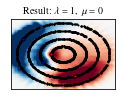

In [161]:
fig, ax = plt.subplots(1, 1, figsize=(1.8, 1.5)) 
# fig, ax = plt.subplots(1, 1, figsize=(10, 7)) 
ax.pcolor(X, Y, Z.reshape((num, num)) / np.sqrt(np.mean(Z**2)), cmap="RdBu_r", vmin=-1, vmax=1)
ax.scatter(x_train[4:, 0], x_train[4:, 1], color='k', s=1, zorder=2)
ax.scatter(x_train[0, 0], x_train[0, 1], color='b', s=10, edgecolor='k', zorder=2)
ax.scatter(x_train[1, 0], x_train[1, 1], color='r', s=10, edgecolor='k', zorder=2)
ax.scatter(x_train[2, 0], x_train[2, 1], color='b', s=10, edgecolor='k', zorder=2)
ax.scatter(x_train[3, 0], x_train[3, 1], color='r', s=10, edgecolor='k', zorder=2)
ax.set_xlim(-4.5, 4.5)
ax.set_ylim(-4.5, 4.5)
ax.tick_params(axis='both', which='major', labelleft=False, labelbottom=False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title(r'Result: $\lambda={},\ \mu={}$'.format(l, m), size=10)
fig.tight_layout()
fig.savefig('savings/krr_{}_{}.pdf'.format(l, m_bis))    

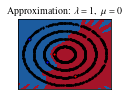

In [162]:
fig, ax = plt.subplots(1, 1, figsize=(1.8, 1.5)) 
# fig, ax = plt.subplots(1, 1, figsize=(10, 7)) 
ax.pcolor(X, Y, np.sign(Z.reshape((num, num))), cmap="RdBu_r", vmin=-1.2, vmax=1.2)
ax.scatter(x_train[4:, 0], x_train[4:, 1], color='k', s=1, zorder=2)
ax.scatter(x_train[0, 0], x_train[0, 1], color='b', s=10, edgecolor='k', zorder=2)
ax.scatter(x_train[1, 0], x_train[1, 1], color='r', s=10, edgecolor='k', zorder=2)
ax.scatter(x_train[2, 0], x_train[2, 1], color='b', s=10, edgecolor='k', zorder=2)
ax.scatter(x_train[3, 0], x_train[3, 1], color='r', s=10, edgecolor='k', zorder=2)
ax.set_xlim(-4.5, 4.5)
ax.set_ylim(-4.5, 4.5)
ax.tick_params(axis='both', which='major', labelleft=False, labelbottom=False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title(r'Approximation: $\lambda={},\ \mu={}$'.format(l, m), size=10)
plt.tight_layout()
fig.savefig('savings/krr_{}_{}_hard.pdf'.format(l, m_bis))    

With full covariance

In [186]:
A = SS @ SS
A /= n
# A += A_d
A += mu * SS
b = SS[..., :nl] @ s_train[:nl]

In [187]:
c = np.linalg.solve(A, b)

In [188]:
Z = S_test_S @ c

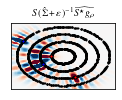

In [192]:
fig, ax = plt.subplots(1, 1, figsize=(1.8, 1.5)) 
# fig, ax = plt.subplots(1, 1, figsize=(10, 7)) 
# ax.pcolor(X, Y, Z.reshape((num, num)) / np.sqrt(np.mean(Z**2)), cmap="RdBu_r", vmin=-1, vmax=1)
ax.pcolor(X, Y, 4*Z.reshape((num, num)) / np.max(np.abs(Z)), cmap="RdBu_r", vmin=-1, vmax=1)
# ax.pcolor(X, Y, np.sign(Z.reshape((num, num))), cmap="RdBu_r", vmin=-1, vmax=1)
ax.scatter(x_train[4:, 0], x_train[4:, 1], color='k', s=1, zorder=2)
ax.scatter(x_train[0, 0], x_train[0, 1], color='b', s=10, edgecolor='k', zorder=2)
ax.scatter(x_train[1, 0], x_train[1, 1], color='r', s=10, edgecolor='k', zorder=2)
ax.scatter(x_train[2, 0], x_train[2, 1], color='b', s=10, edgecolor='k', zorder=2)
ax.scatter(x_train[3, 0], x_train[3, 1], color='r', s=10, edgecolor='k', zorder=2)
ax.set_xlim(-4.5, 4.5)
ax.set_ylim(-4.5, 4.5)
ax.tick_params(axis='both', which='major', labelleft=False, labelbottom=False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title(r'$S(\hat \Sigma + \varepsilon)^{-1} \widehat{S^\star g_\rho}$', size=10)
plt.tight_layout()
fig.savefig('savings/S.pdf'.format(l, m_bis))    

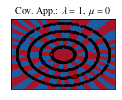

In [170]:
fig, ax = plt.subplots(1, 1, figsize=(1.8, 1.5)) 
# fig, ax = plt.subplots(1, 1, figsize=(10, 7)) 
ax.pcolor(X, Y, np.sign(Z.reshape((num, num))), cmap="RdBu_r", vmin=-1.2, vmax=1.2)
ax.scatter(x_train[4:, 0], x_train[4:, 1], color='k', s=1, zorder=2)
ax.scatter(x_train[0, 0], x_train[0, 1], color='b', s=10, edgecolor='k', zorder=2)
ax.scatter(x_train[1, 0], x_train[1, 1], color='r', s=10, edgecolor='k', zorder=2)
ax.scatter(x_train[2, 0], x_train[2, 1], color='b', s=10, edgecolor='k', zorder=2)
ax.scatter(x_train[3, 0], x_train[3, 1], color='r', s=10, edgecolor='k', zorder=2)
ax.set_xlim(-4.5, 4.5)
ax.set_ylim(-4.5, 4.5)
ax.tick_params(axis='both', which='major', labelleft=False, labelbottom=False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title(r'Cov. App.: $\lambda={},\ \mu={}$'.format(l, m), size=10)
plt.tight_layout()
fig.savefig('savings/krr_{}_{}_fc_hard.pdf'.format(l, m_bis))    

Solution with full representation

In [193]:
A_d = TZ @ TZ.transpose()
A_d /= n
A_d *= lambd

A = (ST.transpose()[..., :nl] @ ST[:nl])
A /= nl
A[:] = 0
A += A_d
A += mu * TT

b = ST.transpose()[..., :nl] @ s_train[:nl]

In [194]:
c = np.linalg.solve(A, b)

In [195]:
# SS_test = get_K(x_train, x_test, sigma)
# SZ_test = get_SZ(x_train, x_test, sigma, SS_test)
# ZZ_test = get_ZZ(x_train, x_test, sigma, SS_test)
# ST_test = get_ST(x_train, x_test, sigma, SS_test, SZ_test)
# TZ_test = get_TZ(x_train, x_test, sigma, SZ_test, ZZ_test)

In [196]:
S_test_S = get_K(x_test, x_train, sigma)
S_test_Z = get_SZ(x_test, x_train, sigma, S_test_S)
Z_test_Z = get_ZZ(x_test, x_train, sigma, S_test_S)
S_test_T = get_ST(x_test, x_train, sigma, S_test_S, S_test_Z)
# T_test_Z = get_TZ(x_test, x_train, sigma, S_test_Z, Z_test_Z)

In [197]:
Z = S_test_T @ c

Figure

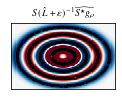

In [198]:
fig, ax = plt.subplots(1, 1, figsize=(1.8, 1.5)) 
# fig, ax = plt.subplots(1, 1, figsize=(10, 7)) 
# ax.pcolor(X, Y, Z.reshape((num, num)) / np.sqrt(np.mean(Z**2)), cmap="RdBu_r", vmin=-1, vmax=1)
ax.pcolor(X, Y, 4 * Z.reshape((num, num)) / np.max(np.abs(Z)), cmap="RdBu_r", vmin=-1, vmax=1)
# ax.pcolor(X, Y, np.sign(Z.reshape((num, num))), cmap="RdBu_r", vmin=-1, vmax=1)
ax.scatter(x_train[4:, 0], x_train[4:, 1], color='k', s=1, zorder=2)
ax.scatter(x_train[0, 0], x_train[0, 1], color='b', s=10, edgecolor='k', zorder=2)
ax.scatter(x_train[1, 0], x_train[1, 1], color='r', s=10, edgecolor='k', zorder=2)
ax.scatter(x_train[2, 0], x_train[2, 1], color='b', s=10, edgecolor='k', zorder=2)
ax.scatter(x_train[3, 0], x_train[3, 1], color='r', s=10, edgecolor='k', zorder=2)
ax.set_xlim(-4.5, 4.5)
ax.set_ylim(-4.5, 4.5)
ax.tick_params(axis='both', which='major', labelleft=False, labelbottom=False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title(r'$S(\hat L + \varepsilon)^{-1} \widehat{S^\star g_\rho}$', size=10)
plt.tight_layout()
fig.savefig('savings/L.pdf'.format(l, m_bis))    

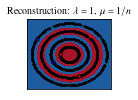

In [109]:
fig, ax = plt.subplots(1, 1, figsize=(1.8, 1.5)) 
# fig, ax = plt.subplots(1, 1, figsize=(10, 7)) 
# ax.pcolor(X, Y, 10*Z.reshape((num, num)) / np.max(np.abs(Z)), cmap="RdBu_r", vmin=-1, vmax=1)
ax.pcolor(X, Y, np.sign(Z.reshape((num, num))), cmap="RdBu_r", vmin=-1.2, vmax=1.2)
ax.scatter(x_train[4:, 0], x_train[4:, 1], color='k', s=1, zorder=2)
ax.scatter(x_train[0, 0], x_train[0, 1], color='b', s=10, edgecolor='k', zorder=2)
ax.scatter(x_train[1, 0], x_train[1, 1], color='r', s=10, edgecolor='k', zorder=2)
ax.scatter(x_train[2, 0], x_train[2, 1], color='b', s=10, edgecolor='k', zorder=2)
ax.scatter(x_train[3, 0], x_train[3, 1], color='r', s=10, edgecolor='k', zorder=2)
ax.set_xlim(-4.5, 4.5)
ax.set_ylim(-4.5, 4.5)
ax.tick_params(axis='both', which='major', labelleft=False, labelbottom=False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title(r'Reconstruction: $\lambda={},\ \mu={}$'.format(l, m), size=10)
plt.tight_layout()
fig.savefig('savings/krr_{}_{}_fhard.pdf'.format(l, m_bis))    

With full covariance

In [90]:
A = ST.transpose() @ ST
A /= n
A += A_d
A += mu * TT

In [91]:
c = np.linalg.solve(A, b)

In [92]:
Z = S_test_T @ c

Figure

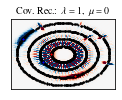

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(1.8, 1.5)) 
# fig, ax = plt.subplots(1, 1, figsize=(10, 7)) 
ax.pcolor(X, Y, Z.reshape((num, num)) / np.sqrt(np.mean(Z**2)), cmap="RdBu_r", vmin=-1, vmax=1)
ax.scatter(x_train[4:, 0], x_train[4:, 1], color='k', s=1, zorder=2)
ax.scatter(x_train[0, 0], x_train[0, 1], color='b', s=10, edgecolor='k', zorder=2)
ax.scatter(x_train[1, 0], x_train[1, 1], color='r', s=10, edgecolor='k', zorder=2)
ax.scatter(x_train[2, 0], x_train[2, 1], color='b', s=10, edgecolor='k', zorder=2)
ax.scatter(x_train[3, 0], x_train[3, 1], color='r', s=10, edgecolor='k', zorder=2)
ax.set_xlim(-4.5, 4.5)
ax.set_ylim(-4.5, 4.5)
ax.tick_params(axis='both', which='major', labelleft=False, labelbottom=False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title(r'Cov. Rec.: $\lambda={},\ \mu={}$'.format(l, m), size=10)
plt.tight_layout()
fig.savefig('savings/krr_{}_{}_fc_f.pdf'.format(l, m_bis))    

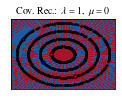

In [94]:
fig, ax = plt.subplots(1, 1, figsize=(1.8, 1.5)) 
# fig, ax = plt.subplots(1, 1, figsize=(10, 7)) 
ax.pcolor(X, Y, np.sign(Z.reshape((num, num))), cmap="RdBu_r", vmin=-1.2, vmax=1.2)
ax.scatter(x_train[4:, 0], x_train[4:, 1], color='k', s=1, zorder=2)
ax.scatter(x_train[0, 0], x_train[0, 1], color='b', s=10, edgecolor='k', zorder=2)
ax.scatter(x_train[1, 0], x_train[1, 1], color='r', s=10, edgecolor='k', zorder=2)
ax.scatter(x_train[2, 0], x_train[2, 1], color='b', s=10, edgecolor='k', zorder=2)
ax.scatter(x_train[3, 0], x_train[3, 1], color='r', s=10, edgecolor='k', zorder=2)
ax.set_xlim(-4.5, 4.5)
ax.set_ylim(-4.5, 4.5)
ax.tick_params(axis='both', which='major', labelleft=False, labelbottom=False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title(r'Cov. Rec.: $\lambda={},\ \mu={}$'.format(l, m), size=10)
plt.tight_layout()
fig.savefig('savings/krr_{}_{}_fc_fhard.pdf'.format(l, m_bis))    